# 4.1 Feature extraction
---

In [9]:
import sys
sys.path.insert(1, '../../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split

data: pd.DataFrame = pd.read_csv('data/prepared.csv', sep=';')

#TODO: como escolher os eixos?
eixo_x = 0
eixo_y = 52
eixo_z = 100
#print(data.columns)

original_copy = data.copy(deep=True)
y: np.ndarray = original_copy.pop('exp').values
X: np.ndarray = original_copy.values

variables = original_copy.columns.values

samples = []
n_samples = 5

for i in range(n_samples):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
    samples.append({'X_train': trnX, 'X_test': tstX,
                  'y_train': trnY, 'y_test': tstY})

#plt.figure()
#plt.xlabel(variables[eixo_y])
#plt.ylabel(variables[eixo_z])
#plt.scatter(data.iloc[:, eixo_y], data.iloc[:, eixo_z])
#plt.show()

## PCA
---

In [17]:
from sklearn.decomposition import PCA

train_transf = []
test_transf = []

for i in range(n_samples):
    data = pd.DataFrame(samples[i]['X_train'])
    test_data = pd.DataFrame(samples[i]['X_test'])
    mean = (data.mean(axis=0)).tolist()
    centered_data = data - mean
    cov_mtx = centered_data.cov()
    eigvals, eigvecs = np.linalg.eig(cov_mtx)

    pca = PCA()
    pca.fit(centered_data)
    PC = pca.components_
    var = pca.explained_variance_
    
    train_transf.append(pca.transform(data))
    test_transf.append(pca.transform(test_data))
    
    print(train_transf[i], test_transf[i])

[[ 8.19725938e+00 -2.12535372e+00  1.56623254e+00 ... -1.28253104e-04
  -4.47077845e-02 -4.91688718e-03]
 [ 5.70676299e+00  3.67488953e+00  2.28127397e+00 ... -4.94078701e-02
   1.53078184e-02 -5.72954006e-02]
 [ 3.53902583e+00  5.11808807e-01  1.42316382e+00 ...  4.49511905e-02
   9.27553691e-04 -2.92914561e-02]
 ...
 [ 2.50469284e+00  2.01343515e-01 -9.65874211e-01 ...  4.25216342e-03
  -6.15139223e-02  2.32795670e-02]
 [ 5.20602985e+00  1.29372776e+00  6.16594927e-01 ... -4.08579183e-02
  -4.25736266e-02  8.09506963e-03]
 [ 3.74003337e+00 -2.01621503e+00 -1.31239861e+00 ...  3.70355597e-03
   4.27986062e-03  1.41773591e-02]] [[ 2.36138549e+00  2.31206371e-01  6.16937654e-01 ... -1.95798609e-02
  -4.70082908e-02  1.89569449e-02]
 [ 2.45581134e+00 -1.12308934e-01 -8.63934156e-01 ...  3.46202117e-02
   8.12759229e-02 -1.11539534e-02]
 [ 5.20790484e+00  3.15828871e-01  3.65370251e+00 ...  5.33270265e-02
  -8.31834496e-02 -2.26245453e-03]
 ...
 [ 5.57676977e+00 -1.66521191e+00 -1.8775343

## Clustering comparison after PCA
---

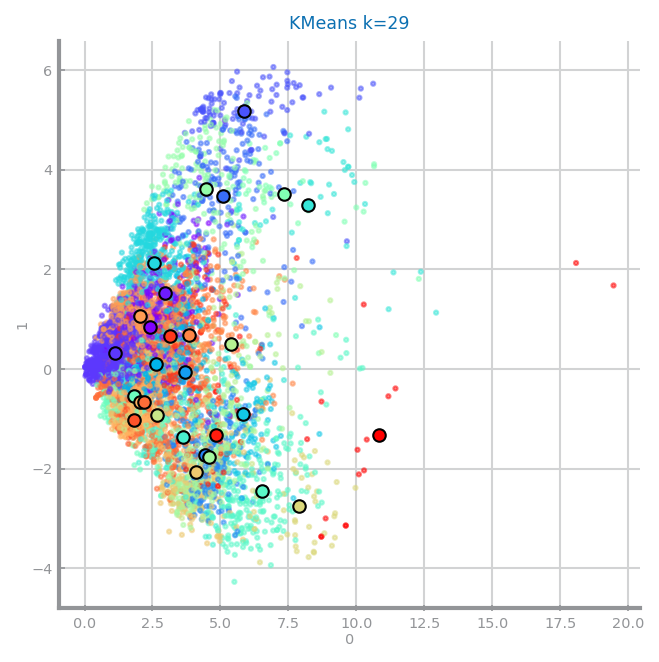

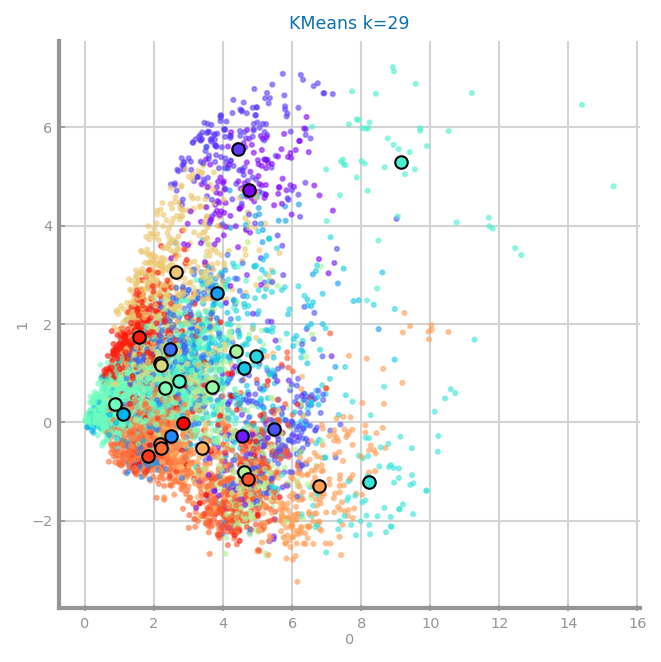

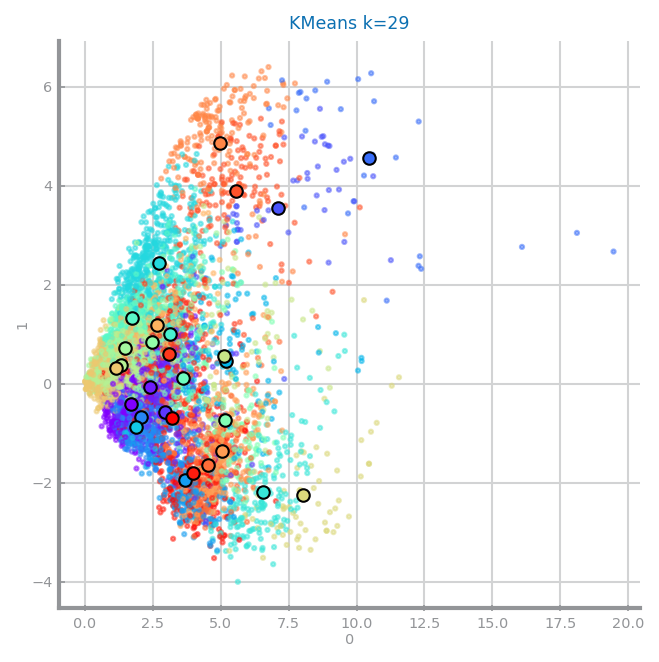

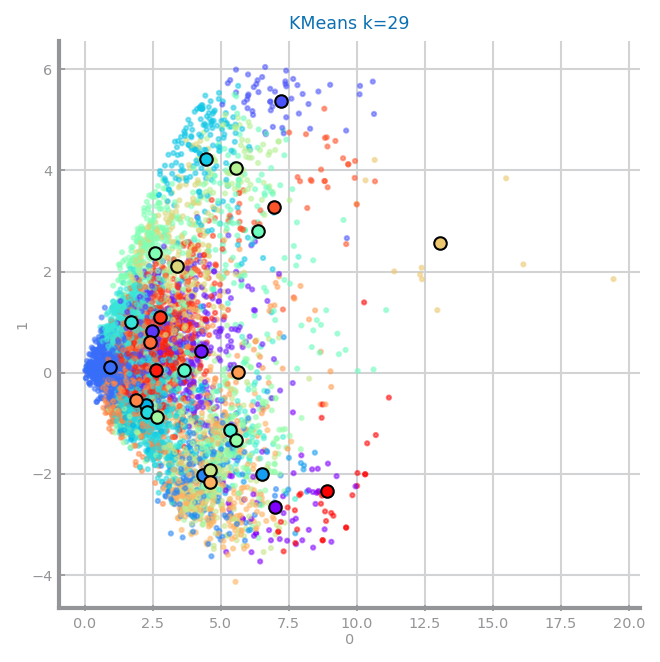

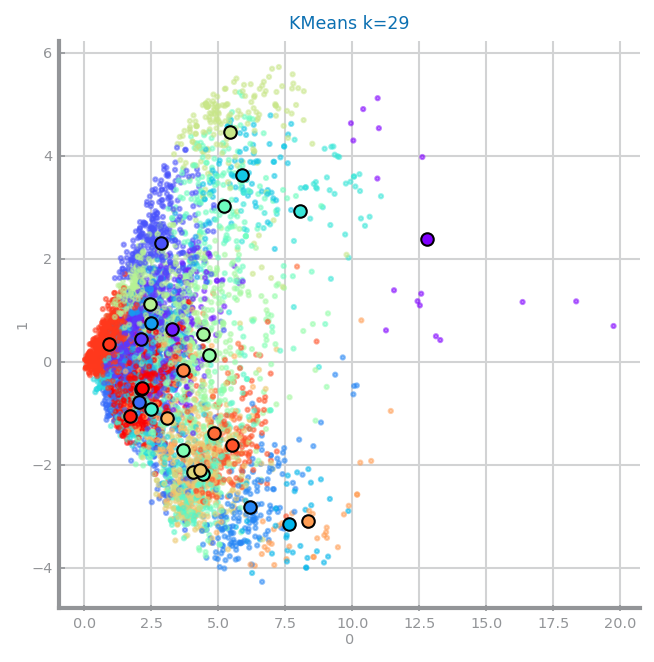

In [29]:
data = pd.DataFrame(transf[:,:2], columns=['PC1', 'PC2'])
eixo_x = 0
eixo_y = 1

N_CLUSTERS = 29
rows, cols = ds.choose_grid(1)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

estimators = []

for i in range(n_samples):
    data = pd.DataFrame(train_transf[i])
    mse: list = []
    sc: list = []
    _, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)

    k = N_CLUSTERS
    estimator = KMeans(n_clusters=k)
    estimator.fit(data)
    estimators.append(estimator)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(data, estimator.labels_))
    ds.plot_clusters(data, eixo_x, eixo_y, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[0,0])
    plt.show()

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

for i in range(1): # (n_samples):
    # Split records per cluster
    clusters = list([[] for _ in range(N_CLUSTERS)])
    y_clusters = list([[] for _ in range(N_CLUSTERS)])
    for l in range(len(estimators[i].labels_)):
        lbl = estimators[i].labels_[l]
        if lbl in clusters:
            clusters[lbl].append(train_transf[i][l])
            y_clusters[lbl].append(samples[i]['y_train'][l])
        else:
            clusters[lbl] = [train_transf[i][l]]
            y_clusters[lbl] = [samples[i]['y_train'][l]]
    print("ok")
    # Train a classifier with records of each cluster
    # TODO: different approach for clusters with only one label
    
    classifiers = {}
    
    for lbl in y_clusters:
        y_c = y_clusters[lbl]
        y1 = y_c[0]
        
        allEqual = True
        for y2 in y_c:
            if y1 != y2:
                allEqual = False
                break
        if allEqual:
            classifiers[lbl] = y1
    print(classifiers)
    input()
        
    #for lbl in sorted(clusters.keys()):
    #    if lbl not in classifiers:
    #        gb = GradientBoostingClassifier(n_estimators=50, max_depth=10, learning_rate=0.3)
    #       gb.fit(np.array(clusters[lbl]), np.array(y_clusters[lbl]))
    #        classifiers[lbl] = gb
    #        print("at " + str(lbl) + "     ", end='\r')
    
    def d(a1, a2):
        return np.linalg.norm(a1 - a2)
    
    len_test = len(test_transf[i])
    nearest = []
    for r in range(len_test):
        record = test_transf[i][r]
        
        centers = estimators[i].cluster_centers_
        min_dist = d(record, centers[0])
        nearest.append(0)
        for c in range(1, len(centers)):
            dist = d(record, centers[c])
            if dist < min_dist:
                min_dist = dist
                nearest[r] = c
        
        
    

ok
{6: False, 19: False}

[ 2.36138549e+00  2.31206371e-01  6.16937654e-01 -1.21366692e+00
  1.76180298e+00  6.37745732e-01 -8.73937619e-01 -1.31143426e+00
 -9.38067592e-01  4.80868925e-01 -1.25185446e+00 -7.10459169e-01
 -2.99406236e-01 -1.45286537e+00  9.02829717e-01 -3.31494310e-02
  1.36115716e+00  3.32547763e-01 -2.44738733e-01 -2.24519680e-01
 -4.29666507e-01  5.83007690e-01  4.74253883e-02 -4.73242994e-01
  1.05468782e-01 -7.49295775e-01  1.14943244e-01  5.35934219e-01
  6.80244483e-01  8.57192882e-02 -7.12462830e-01 -1.57127642e-01
 -1.23522553e-01 -4.49070451e-01 -8.04749846e-01  3.68899688e-01
 -1.63336567e-01  3.08075098e-01  2.24277224e-01  4.34968056e-01
  1.03469345e+00  4.03449741e-02 -1.23052919e+00 -7.87604505e-01
 -6.28649858e-01  7.55109327e-02  7.21857023e-01 -2.82014483e-02
  2.17572137e-01  1.62100162e-01 -4.79659709e-01  2.55900062e-02
  1.66513559e-02  1.86171098e-01 -2.28744314e-01 -9.62664690e-02
  7.49329327e-01  4.39185677e-01  2.92307516e-01 -2.01708316e-01

KeyboardInterrupt: Interrupted by user